In [108]:
from tensorflow.data import Dataset
import tensorflow as tf

In [20]:
dataset = Dataset.range(10)

In [21]:
dataset = dataset.shuffle(buffer_size=1).batch(5)
for data in dataset:
    print(data)

tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int64)
tf.Tensor([5 6 7 8 9], shape=(5,), dtype=int64)


In [103]:
class RunName():
    def __init__(self):
        self.num = 0
        return
    
    def __call__(self, fn, suffix):
        self.num += 1
        return f'{fn}_{self.num:04d}{suffix}'

## Prepare housing data by splitting it to multiple csv files

In [104]:
## Prepare housing split dataset to test Dataset API
import os
import csv

FP = './datasets/housing_split/housing.csv'
SPLIT_PATH = './datasets/housing_split/train_datasets'
os.makedirs(SPLIT_PATH, exist_ok=True)

SPLIT_FN = 'housing'
# SPLIT_FP = os.path.join(SPLIT_PATH, SPLIT_FN)

n_rows = 8

with open(FP, 'r') as f:
    reader = csv.reader(f)
    attrib_name = next(reader)
    run_name = RunName()

    for num_line, line in enumerate(reader):
        
        if num_line % n_rows == 0:
            run_split_fn = run_name(SPLIT_FN, '.csv')
            run_split_fp = os.path.join(SPLIT_PATH, run_split_fn)
            
            with open(run_split_fp, 'w') as fp:
                writer = csv.writer(fp)
                writer.writerow(attrib_name)
        
        with open(run_split_fp, 'a') as fp:
            writer = csv.writer(fp)
            writer.writerow(line[:-1])

## Using dataset api from tensorflow to process data from disk

In [190]:
tf.random.set_seed(42)

list_files = Dataset.list_files(SPLIT_PATH + '/*.csv')

for data in list_files.take(5):
    print(data)

tf.Tensor(b'./datasets/housing_split/train_datasets/housing_1655.csv', shape=(), dtype=string)
tf.Tensor(b'./datasets/housing_split/train_datasets/housing_0963.csv', shape=(), dtype=string)
tf.Tensor(b'./datasets/housing_split/train_datasets/housing_0557.csv', shape=(), dtype=string)
tf.Tensor(b'./datasets/housing_split/train_datasets/housing_0566.csv', shape=(), dtype=string)
tf.Tensor(b'./datasets/housing_split/train_datasets/housing_0845.csv', shape=(), dtype=string)


In [191]:
def parse_text_line(fp):
    return tf.data.TextLineDataset(fp).skip(1)

interleave = list_files.interleave(parse_text_line, cycle_length = 5)

for data in interleave.take(19):
    print(data)

tf.Tensor(b'-118.28,33.98,43.0,1240.0,312.0,1100.0,311.0,1.575,97500.0', shape=(), dtype=string)
tf.Tensor(b'-122.25,37.82,26.0,3959.0,1196.0,1749.0,1217.0,3.0233,255000.0', shape=(), dtype=string)
tf.Tensor(b'-119.79,36.79,26.0,1700.0,423.0,909.0,386.0,2.256,64500.0', shape=(), dtype=string)
tf.Tensor(b'-118.41,34.0,35.0,684.0,161.0,381.0,159.0,2.8393,272000.0', shape=(), dtype=string)
tf.Tensor(b'-117.09,32.64,38.0,2095.0,536.0,1240.0,550.0,2.7218,145900.0', shape=(), dtype=string)
tf.Tensor(b'-118.27,33.98,45.0,1696.0,424.0,1502.0,429.0,1.3042,99200.0', shape=(), dtype=string)
tf.Tensor(b'-122.25,37.83,52.0,2376.0,559.0,939.0,519.0,3.1484,224100.0', shape=(), dtype=string)
tf.Tensor(b'-119.79,36.79,19.0,1524.0,448.0,960.0,386.0,1.5122,47500.0', shape=(), dtype=string)
tf.Tensor(b'-118.41,34.0,30.0,3550.0,934.0,3738.0,880.0,3.191,271200.0', shape=(), dtype=string)
tf.Tensor(b'-117.09,32.64,30.0,3171.0,862.0,2126.0,800.0,2.507,142700.0', shape=(), dtype=string)
tf.Tensor(b'-118.27,33.

In [192]:
def parse_bin_to_float(tensor):
    default = [0.]*8 + [tf.constant([], dtype = tf.float32)]
    tensors = tf.io.decode_csv(tensor, record_defaults=default)
    return tensors[:-1], tensors[-1]

mapped_dataset = interleave.map(parse_bin_to_float)

for data in mapped_dataset.take(2):
    print(data)

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-121.93  ,   36.62  ,   39.    ,  869.    ,  173.    ,  406.    ,
        165.    ,    4.0313], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=253800.0>)
(<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-121.34  ,   38.64  ,   12.    , 2772.    ,  578.    , 1335.    ,
        565.    ,    3.8068], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=161000.0>)


In [193]:
shuffled_dataset = mapped_dataset.shuffle(buffer_size = 100).batch(32).prefetch(2)

for data in shuffled_dataset.take(1):
    print(len(data))

2


In [194]:
## Aggregate to one function
def csv_generator(fp):
    
    tf.random.set_seed(42)
    list_files = Dataset.list_files(fp + '/*.csv')
    interleave = list_files.interleave(
        parse_text_line, cycle_length = 5
    )
    mapped_dataset = interleave.map(parse_bin_to_float)
    shuffled_dataset = mapped_dataset.shuffle(buffer_size = 100).batch(32).prefetch(2)
    
    return shuffled_dataset

## Now, we ready for training the model!

In [176]:
from tensorflow.keras.layers import BatchNormalization, Dense
from tensorflow.keras.models import Sequential

In [195]:
tf.keras.backend.clear_session()

model = Sequential([
    BatchNormalization(input_shape=[8]),
    Dense(100, activation = 'selu'),
    Dense(100, activation = 'selu'),
    Dense(1)
])

model.compile(loss='huber', metrics=['mae'], optimizer = 'adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 8)                 32        
_________________________________________________________________
dense (Dense)                (None, 100)               900       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 11,133
Trainable params: 11,117
Non-trainable params: 16
_________________________________________________________________


In [196]:
TRAIN_PATH = './datasets/housing_split/train_datasets'
VALID_PATH = './datasets/housing_split/valid_datasets'
TEST_PATH = './datasets/housing_split/test_datasets'

train_dataset = csv_generator(TRAIN_PATH)
valid_dataset = csv_generator(VALID_PATH)
test_dataset = csv_generator(TEST_PATH)

model.fit(train_dataset,
          validation_data=valid_dataset, 
          epochs=10)

Epoch 1/10
470/470 [==============================] - 2s 5ms/step - loss: 196160.8438 - mae: 196161.3906 - val_loss: 224110.5781 - val_mae: 224111.0781
Epoch 2/10
470/470 [==============================] - 2s 4ms/step - loss: 169965.7812 - mae: 169966.3125 - val_loss: 172043.1406 - val_mae: 172043.6406
Epoch 3/10
470/470 [==============================] - 2s 5ms/step - loss: 100920.8438 - mae: 100921.3359 - val_loss: 104064.3984 - val_mae: 104064.8984
Epoch 4/10
470/470 [==============================] - 2s 5ms/step - loss: 76872.1953 - mae: 76872.6953 - val_loss: 97669.0000 - val_mae: 97669.5000
Epoch 5/10
470/470 [==============================] - 2s 5ms/step - loss: 72817.0156 - mae: 72817.4844 - val_loss: 93940.8672 - val_mae: 93941.3672
Epoch 6/10
470/470 [==============================] - 2s 5ms/step - loss: 68556.5469 - mae: 68557.0469 - val_loss: 90925.2422 - val_mae: 90925.7422
Epoch 7/10
470/470 [==============================] - 2s 5ms/step - loss: 63709.4062 - mae: 63709.91

## TFRecord testing

In [198]:
import tensorflow as tf
import os

In [203]:
PROTOC_PATH = './datasets/ch10-protobuf-testing'
PROTOC_NAME = 'my_test.tfrecord'
os.makedirs(PROTOC_PATH, exist_ok = True)

Fill the data in tfrecord

In [206]:
with tf.io.TFRecordWriter(PROTOC_PATH + '/' + PROTOC_NAME) as f:

    f.write('Test')
    f.write(b'Test2')

In [207]:
dataset = tf.data.TFRecordDataset(PROTOC_PATH + '/' + PROTOC_NAME)

for data in dataset:
    print(data)

tf.Tensor(b'Test', shape=(), dtype=string)
tf.Tensor(b'Test2', shape=(), dtype=string)


Record image!

In [219]:
from sklearn.datasets import load_sample_image, load_sample_images
from tensorflow.train import Example, Features, Feature, BytesList
import matplotlib.pyplot as plt

In [216]:
img = load_sample_images()['images'][1]

In [226]:
img_protobuf = Example(features = Features(feature = {
    'img':Feature(bytes_list=BytesList(value = [tf.io.encode_jpeg(img).numpy()]))
}))

In [228]:
with tf.io.TFRecordWriter(PROTOC_PATH + '/' + 'example_w_img.tfrecord') as f:
    f.write(img_protobuf.SerializeToString())

In [230]:
dataset = tf.data.TFRecordDataset(PROTOC_PATH + '/' + 'example_w_img.tfrecord')

In [236]:
for data in dataset:
    decode_img = tf.io.parse_single_example(data, {'img':tf.io.VarLenFeature(dtype = tf.string)})

In [247]:
decode_img = tf.io.decode_image(decode_img['img'].values[0])

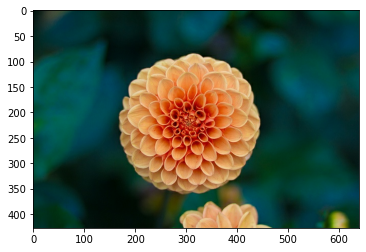

In [248]:
plt.imshow(decode_img)

# Exercise

## Question 1

Data API is designed for tackling with bigdata which cannot be fit in memory. It can gradually read the data from multiple files in a disk or even multiple servers.  
Also, it offers many features, such as batching, prefetching, interleaving, reading data in parallel from multiple sources.

## Question 2

If the data is too large to fit in the memory, we should split the data into small multiple files. We, then, can gradually read these data and train the model. And, if the data is separate across multiples servers, it will be beneficial to simultaneously download data from which utilizes the bandwidth usage.

## Question 3

Using tensorboard, we can measure GPU usage, if it is not fully utilized then the input pipeline is likely to be the bottelneck. Sometimes, it can dramatically boost the performance by just prefetch the training batch using CPU while training the data in GPU.

## Question 4

TFRecord can save any binary format, however, the protobuf format is more portable to another platform and another language.

## Question 5

Example is the predefined protobuf format implement in python clas and tensorflow provides some operation to parse it. However, if it doesn't cover our use case, we can compile the definition of our protobuf by ourselves.

## Question 6

If the file is too large, we can compress the binary file before recording in TFRecord, especially, if the recording data need to be use in another machine. However, it will increase computional cost.

## Question 7

* If we process the data before writing the data files, the raw data will be lost forever, and thus, we should not use this method. Unless, we really doesn't need to use the raw data.  
* tf.data is used only for training period, because it can not be used in production.  
* Preprocssing layers seems to be a good choice because it can be used in production as well, however, if the preprocessing cost is expensive. The training time will be longer, since one instance have to be unnecessary prepocessed every epoch.  
* TFTransform is preferred before the above method if the preprocessing cost is expensive. Because we need to use spark or apache beam to preprocess the raw data. TFTransform will factiliate us in doing such that. But the learning curve of this tool is steep.

## Question 8

* One Hot Encoding --> convert categorical feature into many of binary features 
* Ordinal Encoding --> convert categorical feature into one integer features 
* Embedding Encoding --> convert categorical feature into learnable vector features  
For text processing, we have.  
* Word embedding. 
* Bag-of-word --> counting the frequency of the word appeared in the corpus. 
* Term Frequency - Inverse Domain Frequency (TF-IDF) --> normalized version of bag-of-word, preventing the model to bias for the useless frequent word, such as 'the', 'a', 'and'. 
* n-grams


## Question 9

In [92]:
import os
import tensorflow.keras.datasets as tfds
import tensorflow as tf
from tensorflow.train import Example, Features, BytesList, Int64List, Feature
from tensorflow.io import encode_png, decode_image, TFRecordWriter, serialize_tensor, parse_single_example, parse_tensor, FixedLenFeature, VarLenFeature
from tensorflow.data import TFRecordDataset
from tensorflow.image import encode_png as tfep
import matplotlib.pyplot as plt
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

TRAIN_PATH = './datasets/ch13-preprocessing/train_set'
VALID_PATH = './datasets/ch13-preprocessing/valid_set'
TEST_PATH = './datasets/ch13-preprocessing/test_set'

os.makedirs('./datasets/ch13-preprocessing', exist_ok=True)
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(VALID_PATH, exist_ok=True)
os.makedirs(TEST_PATH, exist_ok=True)

In [44]:
(X_fulltrain, y_fulltrain), (X_test, y_test) = tfds.mnist.load_data()

In [45]:
X_train, X_valid = X_fulltrain[5000:], X_fulltrain[:5000]
y_train, y_valid = y_fulltrain[5000:], y_fulltrain[:5000]
print(X_train.shape)
print(X_test.shape)

(55000, 28, 28)
(10000, 28, 28)


In [76]:
train_dataset = Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=55000)
valid_dataset = Dataset.from_tensor_slices((X_valid, y_valid))
test_dataset = Dataset.from_tensor_slices((X_test, y_test))

In [77]:
def create_example(X, y):
    example = Example(features = Features(feature = {
        'img': Feature(bytes_list = BytesList(value = [serialize_tensor(X).numpy()])),
        'label': Feature(int64_list = Int64List(value = [y]))
    }))
    
    return example

In [82]:
from contextlib import ExitStack

def create_tfrecord_shard(path, dataset, num_shard=10):
    
    with ExitStack() as stack:
        writers = [stack.enter_context(TFRecordWriter(f'{path}/img_shard_{i:03d}.tfrecord')) for i in range(num_shard)]
        
        for ind, data in enumerate(dataset):
            example = create_example(data[0], data[1])
            shard = ind%num_shard
            writers[shard].write(example.SerializeToString())

In [83]:
create_tfrecord_shard(TRAIN_PATH, train_dataset)
create_tfrecord_shard(VALID_PATH, valid_dataset)
create_tfrecord_shard(TEST_PATH, test_dataset)

In [89]:
tfrecords = TFRecordDataset([f'{TRAIN_PATH}/img_shard_{i:03d}.tfrecord' for i in range(10)])

In [95]:
features_description = {
    'img': FixedLenFeature([], tf.string, default_value=""),
    'label': FixedLenFeature([], tf.int64, default_value=-1)

}

for tfrecord in tfrecords.take(1):
    decode_example = parse_single_example(tfrecord, features_description)
    img = parse_tensor(decode_example['img'], out_type = tf.uint8)
    print(img.shape)

(28, 28)


In [98]:
print(type(tfrecords.shuffle(buffer_size=60000)))

<class 'tensorflow.python.data.ops.dataset_ops.ShuffleDataset'>


In [105]:
for data in train_dataset.take(1):
    print(type(data[0]))
    print(type(data[1]))
    print(type(tf.range(10)))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [146]:
## Create train valid and testset from tfrecord

In [244]:
new_trainset = tf.data.Dataset.list_files(TRAIN_PATH+'/*.tfrecord').interleave(
    lambda x : TFRecordDataset(x), cycle_length=2)

Cause: could not parse the source code:

    lambda x : TFRecordDataset(x), cycle_length=2)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

    lambda x : TFRecordDataset(x), cycle_length=2)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [245]:
features_description = {'img': FixedLenFeature([], tf.string), 'label':FixedLenFeature([], tf.int64)}

def get_example(serialize, fd = features_description):
    example = parse_single_example(serialize, features_description)
    return example

def preprocess(serialize):
    example = get_example(serialize)
    X = tf.cast(tf.reshape(parse_tensor(example['img'], tf.uint8), (28, 28)),tf.float32)
    y = example['label']
    return X, y

In [246]:
new_trainset = new_trainset.map(preprocess).shuffle(buffer_size = 100).batch(32).prefetch(2)

In [247]:
def get_dataset_fr_tfrecord(path):
    dataset = tf.data.Dataset.list_files(path+'/*.tfrecord').interleave(
        lambda x : TFRecordDataset(x), cycle_length=2)
    dataset = dataset.map(preprocess).shuffle(buffer_size = 100).batch(32).prefetch(2)
    return dataset

In [248]:
## Create basic model for training this new_trainset
new_trainset = get_dataset_fr_tfrecord(TRAIN_PATH)
new_validset = get_dataset_fr_tfrecord(VALID_PATH)
new_testset = get_dataset_fr_tfrecord(TEST_PATH)

Cause: could not parse the source code:

        lambda x : TFRecordDataset(x), cycle_length=2)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

        lambda x : TFRecordDataset(x), cycle_length=2)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

        lambda x : TFRecordDataset(x), cycle_length=2)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

        lambda x : TFRecordDataset(x), cycle_length=2)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warnin

In [249]:
for data in new_validset.take(2):
    print(data[0])

tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]

In [202]:
## Create simple model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorboard as tb
import datetime

In [217]:
tf.keras.backend.clear_session()

model = Sequential([
    Input(shape=[28, 28]),
    Flatten(),
    Dense(100, activation = 'elu'),
    Dense(100, activation = 'elu'),
    Dense(10, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', metrics=['accuracy'], optimizer = 'adam')

In [218]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [219]:
model.layers[0].variables

[]

In [220]:
log_dir = "./datasets/ch13-preprocessing/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=10)

model.fit(new_trainset, epochs = 10, validation_data=new_validset, callbacks=[tensorboard_callback])

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.8903 - accuracy: 0.8630 - val_loss: 0.4855 - val_accuracy: 0.9026
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3683 - accuracy: 0.9171 - val_loss: 0.3276 - val_accuracy: 0.9310
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2986 - accuracy: 0.9289 - val_loss: 0.2608 - val_accuracy: 0.9408
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2455 - accuracy: 0.9389 - val_loss: 0.2294 - val_accuracy: 0.9406
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1896 - accuracy: 0.9505 - val_loss: 0.1877 - val_accuracy: 0.9558
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1562 - accuracy: 0.9577 - val_loss: 0.2009 - val_accuracy: 0.9510
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1441 - accuracy: 0.9605 - val_loss: 0.1616 - val_accuracy:

In [274]:
model(list(new_testset.take(1).as_numpy_iterator())[0][0][0:1])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[3.1985949e-16, 5.0129040e-10, 4.4165503e-08, 1.0000000e+00,
        1.0396447e-12, 2.5880301e-08, 1.5311456e-18, 1.8096690e-14,
        2.1297334e-11, 3.2575412e-12]], dtype=float32)>

In [278]:
%load_ext tensorboard
%tensorboard --logdir ./datasets/ch13-preprocessing/logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 59884), started 0:30:13 ago. (Use '!kill 59884' to kill it.)

In [222]:
## Model with normalization preprocessing

In [250]:
from tensorflow.keras.layers import LayerNormalization

In [251]:
class StandardizationLayer(tf.keras.layers.Layer):
    def adapt(self, data_sample):
        self.mean_ = tf.reduce_mean(data_sample, axis = 0, keepdims=True)
        self.std_ = tf.math.reduce_std(data_sample, axis = 0, keepdims = True)
    
    def call(self, input_):
        return (input_ - self.mean_)/(self.std_ + tf.keras.backend.epsilon())

In [252]:
# Aadapt Std layer

std_layer = StandardizationLayer()

data_sample = new_trainset.take(100).map(lambda img, label : img)
sample_images = np.concatenate(list(data_sample.as_numpy_iterator()),
                               axis=0).astype(np.float32)
std_layer.adapt(sample_images)

for data in data_sample.take(1):
    print(std_layer(data))

tf.Tensor(
[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ... -0.01891408  0.
    0.        ]
  ...
  [ 0.          0.          0.         ... -0.01767977 -0.01768059
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ... -0.01891408  0.
    0.        ]
  ...
  [ 0.          0.          0.         ... -0.01767977 -0.01768059
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0

In [253]:
std_layer.mean_

<tf.Tensor: shape=(1, 28, 28), dtype=float32, numpy=
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 2.65625007e-02, 7.90624991e-02,
         7.09374994e-02, 7.81250000e-03, 1.17500000e-01, 1.76249996e-01,
         1.66562498e-01, 2.57499993e-01, 2.20937505e-01, 9.34375003e-02,
         2.02500001e-01, 1.90937504e-01, 1.25000000e-01, 1.12187497e-01,
         8.50000009e-02, 7.18749985e-02, 1.01562500e-01, 6.62499964e-0

In [279]:
tf.keras.backend.clear_session()

new_model = Sequential([
    Input(shape=[28, 28]),
    std_layer,
    Flatten(),
    Dense(100, activation = 'relu'),
])

new_model.add(Dense(100, activation = 'relu'))
new_model.add(Dense(10, activation = 'softmax'))

new_model.compile(loss = 'sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
standardization_layer_12 (St (None, 28, 28)            0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [280]:
log_dir = "./datasets/ch13-preprocessing/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=10)

new_model.fit(new_trainset, epochs = 10, validation_data=new_validset, callbacks=[tensorboard_callback])

Epoch 1/10
      1/Unknown - 0s 85us/step - loss: 9609053.0000 - accuracy: 0.1562WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0023s vs `on_train_batch_end` time: 0.0057s). Check your callbacks.
1719/1719 [==============================] - 7s 4ms/step - loss: 118096.6172 - accuracy: 0.9163 - val_loss: 221962.6250 - val_accuracy: 0.9492
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 47181.9258 - accuracy: 0.9536 - val_loss: 178490.4688 - val_accuracy: 0.9530
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 27038.2637 - accuracy: 0.9606 - val_loss: 94094.0859 - val_accuracy: 0.9522
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 14235.8438 - accuracy: 0.9657 - val_loss: 61551.1797 - val_accuracy: 0.9556
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 8777.8271 - accuracy: 0.9711 - val_loss: 50767.5234 - val_accuracy:

In [281]:
%load_ext tensorboard
%tensorboard --logdir ./datasets/ch13-preprocessing/logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 59884), started 0:33:27 ago. (Use '!kill 59884' to kill it.)

In [282]:
new_model(list(new_testset.take(1).as_numpy_iterator())[0][0][0:1])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[2.0730959e-06, 4.8182956e-06, 1.8192634e-04, 1.2669700e-05,
        1.3650000e-06, 1.9688277e-05, 6.7990433e-05, 1.7676841e-07,
        9.9970466e-01, 4.6830082e-06]], dtype=float32)>

In [283]:
new_model.evaluate(new_testset)

313/313 [==============================] - 1s 3ms/step - loss: 12661.2920 - accuracy: 0.9589


[12661.2919921875, 0.958899974822998]

In [284]:
model.evaluate(new_testset)

313/313 [==============================] - 1s 4ms/step - loss: 0.1824 - accuracy: 0.9558


[0.18235553801059723, 0.9557999968528748]

## WIth normalization layer, the performance is better

## Question 10

In [307]:
from tensorflow.data import Dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import text_dataset_from_directory
import os

In [308]:
DATA_ROOT = './datasets/ch13-preprocessing/movie-reviews'
root_num = len(DATA_ROOT.split('/'))

for root, dirs, files in os.walk(DATA_ROOT):
    splitted = root.split('/')
    indent = len(splitted) - root_num
    print("    "*(indent) + splitted[-1] +'/')
    
    for num, file in enumerate(files):
        if num == 3:
            print("    "*(indent + 1) + '...')
            break
        print("    "*(indent + 1) + file)

movie-reviews/
    urls_unsup.txt
    .DS_Store
    imdbEr.txt
    ...
    aclImdb/
        .DS_Store
        test/
            .DS_Store
            neg/
                1821_4.txt
                9487_1.txt
                4604_4.txt
                ...
            pos/
                4715_9.txt
                1930_9.txt
                3205_9.txt
                ...
        train/
            .DS_Store
            neg/
                1821_4.txt
                10402_1.txt
                1062_4.txt
                ...
            pos/
                4715_9.txt
                12390_8.txt
                8329_7.txt
                ...


In [305]:
for x, y in (([1,2,3,4], 'x'), ([5, 6, 7, 8], 'u')):
    print(f'x {x}')
    print(f'y {y}')

x [1, 2, 3, 4]
y x
x [5, 6, 7, 8]
y u


In [508]:
trainset = text_dataset_from_directory(DATA_ROOT + '/aclImdb/train', 
                                                 validation_split=0.2, subset='training',
                                                 seed=42, )

validset = text_dataset_from_directory(DATA_ROOT + '/aclImdb/train', 
                                                 validation_split=0.2, subset='validation',
                                                 seed=42
                                                )

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [509]:
for data in trainset.take(1):
    print(data[0].numpy()[0])

b"Mild Spoilers<br /><br />In the near future, Arnold stars as Ben Richards, a wrongly convicted man coerced into playing 'The Running Man', a deadly TV game show where people have to keep moving to try and escape brutal deaths at the hands of the 'Stalkers'. Of course, people are expected to die eventually and its up to Arnold to prove the system wrong.<br /><br />I haven't read the Stephen King book, but this is a great film regardless, one of Arnold's best. He does what he does best in the action man role, delivering death with unforgettable one-liners. Classics are probably the 'He was a real pain in the neck' after strangling a guy with barb wire, and 'He had to split!', referring to whereabouts he just chain sawed someone vertically. Dawson is perfectly irritating as the TV presenter, and all the 'Stalkers' are suitably camp. The action is violent, but its an action film. That's the point. The film is fast paced, and at 90 minutes it doesn't overstay its welcome. <br /><br />With

In [646]:
# using textvectorization
from collections import Counter

def preprocess(text, n_words = 50):
    shape = tf.shape(text)* tf.constant([1, 0]) + tf.constant([0, n_words])
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, b"<[^>]+>", b" ")
    text = tf.strings.regex_replace(text, b"[^a-z]",b" ")
    text = tf.strings.split(text)
    text = text.to_tensor(shape = shape, default_value=b"<pad>")
    return text


def get_vocab(text, n_vocab=1000):
    counter = Counter()
    text_batchs = preprocess(text)
    
    for batch in text_batchs:
        for text in batch:
            if text != '<pad>':
                counter[text.numpy()] += 1
                
    return tf.constant(['<pad>']+[word for word, count in counter.most_common(n_vocab)])

In [621]:
preprocess([b"test, suk t", b'What the hack'])

<tf.Tensor: shape=(2, 50), dtype=string, numpy=
array([[b'test', b'suk', b't', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>'],
       [b'what', b'the', b'hack', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'

In [644]:
tf.random.set_seed(42)
concat_data = tf.constant([""])
for data in trainset:
    concat_data = tf.concat([concat_data, data[0]], axis = 0)

get_vocab(concat_data)

## Create self customize TextVectorization Layer

In [655]:
class TextVectorization(tf.keras.layers.Layer):
    def __init__(self, max_vocab_size=1000, n_oov_buckets=100, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.max_vocab_size = max_vocab_size
        self.n_oov_buckets = n_oov_buckets
        
    def adapt(self, data_example):
        self.vocab = get_vocab(data_example, self.max_vocab_size)
        word_idx = tf.range(len(self.vocab), dtype = tf.int64)
        vocab_init = tf.lookup.KeyValueTensorInitializer(self.vocab, word_idx)
        print(vocab_init)
        self.table = tf.lookup.StaticVocabularyTable(vocab_init, self.n_oov_buckets)
        
    def call(self, data):
        texts = preprocess(data)
        return self.table.lookup(texts)

In [ ]:
def preprocess(X_batch, n_words=50):
    shape = tf.shape(X_batch) * tf.constant([1, 0]) + tf.constant([0, n_words])
    Z = tf.strings.substr(X_batch, 0, 300)
    Z = tf.strings.lower(Z)
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ")
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")
    Z = tf.strings.split(Z)
    Z = Z.to_tensor(shape=shape, default_value=b"<pad>")

    return Z

def get_vocabulary(data_sample, max_size=1000):
    preprocessed_reviews = preprocess(data_sample).numpy()
    counter = Counter()
    for words in preprocessed_reviews:
        for word in words:
            if word != b"<pad>":
                counter[word] += 1
    return [b"<pad>"] + [word for word, count in counter.most_common(max_size)]

class TextVectorization2(tf.keras.layers.Layer):
    def __init__(self, max_vocabulary_size=1000, n_oov_buckets=100, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.max_vocabulary_size = max_vocabulary_size
        self.n_oov_buckets = n_oov_buckets

    def adapt(self, data_sample):
        self.vocab = get_vocabulary(data_sample, self.max_vocabulary_size)
        words = tf.constant(self.vocab)
        word_ids = tf.range(len(self.vocab), dtype=tf.int64)
        vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
        self.table = tf.lookup.StaticVocabularyTable(vocab_init, self.n_oov_buckets)
        
    def call(self, inputs):
        preprocessed_inputs = preprocess(inputs)
        return self.table.lookup(preprocessed_inputs)

In [669]:
print(text_vect.table.lookup(tf.constant('ggwpefuncka', dtype=tf.string)))

tf.Tensor(1036, shape=(), dtype=int64)


In [657]:
text_vect = TextVectorization(input_shape = [])
text_vect.adapt(concat_data)

In [658]:
text_vect(concat_data)

<tf.Tensor: shape=(20001, 50), dtype=int64, numpy=
array([[   0,    0,    0, ...,    0,    0,    0],
       [1087, 1005, 1046, ..., 1087,    7, 1012],
       [  38,  435,  103, ...,   17, 1100,  500],
       ...,
       [  16,   85,   30, ..., 1006,   13,  390],
       [   5,  484,    6, ...,  959,  465, 1014],
       [   5,  213,    2, ...,  263,    3,  181]])>

In [649]:
class BagOfWords(tf.keras.layers.Layer):
    def __init__(self, n_tokens, dtype=tf.int32, **kwargs):
        super().__init__(dtype=tf.int32, **kwargs)
        self.n_tokens = n_tokens
    def call(self, inputs):
        one_hot = tf.one_hot(inputs, self.n_tokens)
        return tf.reduce_sum(one_hot, axis=1)[:, 1:]

In [629]:
bg = BagOfWords(1000)
bg(text_vect(concat_data))

<tf.Tensor: shape=(97, 999), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 4., 0., ..., 0., 0., 0.],
       [5., 2., 1., ..., 0., 0., 0.],
       [3., 3., 4., ..., 0., 0., 0.]], dtype=float32)>

In [630]:
print(tf.shape(concat_data))

tf.Tensor([97], shape=(1,), dtype=int32)


In [650]:
# create simple model
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

In [651]:
tf.keras.backend.clear_session()

n_tokens = 1000 + 100 + 1

model = Sequential([
    text_vect,
    BagOfWords(n_tokens),
    Dense(100, activation = 'elu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(100, activation = 'elu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid')
])

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer = 'adam')

In [642]:
for data in trainset.take(1):
    print(tf.shape(data[0]))

tf.Tensor([32], shape=(1,), dtype=int32)


In [652]:
model.fit(trainset,
          epochs = 10, validation_data=validset)

Epoch 1/10
625/625 [==============================] - 28s 45ms/step - loss: 0.6812 - accuracy: 0.6441 - val_loss: 0.5348 - val_accuracy: 0.7244
Epoch 2/10
625/625 [==============================] - 14s 22ms/step - loss: 0.5418 - accuracy: 0.7261 - val_loss: 0.5232 - val_accuracy: 0.7344
Epoch 3/10
625/625 [==============================] - 15s 24ms/step - loss: 0.5147 - accuracy: 0.7443 - val_loss: 0.5199 - val_accuracy: 0.7352
Epoch 4/10
625/625 [==============================] - 12s 20ms/step - loss: 0.5026 - accuracy: 0.7474 - val_loss: 0.5209 - val_accuracy: 0.7326
Epoch 5/10
625/625 [==============================] - 15s 24ms/step - loss: 0.4975 - accuracy: 0.7528 - val_loss: 0.5197 - val_accuracy: 0.7362
Epoch 6/10
625/625 [==============================] - 15s 24ms/step - loss: 0.4901 - accuracy: 0.7581 - val_loss: 0.5181 - val_accuracy: 0.7334
Epoch 7/10
625/625 [==============================] - 22s 36ms/step - loss: 0.4850 - accuracy: 0.7614 - val_loss: 0.5226 - val_accuracy:

In [617]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization2_10 (Text (None, None)              0         
_________________________________________________________________
bag_of_words (BagOfWords)    (None, 999)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               100000    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 110,201
Trainable params: 110,201
Non-trainable params: 0
_________________________________________________________________


In [570]:
## Customize fit function in the model
class MyModel(tf.keras.Model):
    def train_step(self, data):
        
        x, y = data
        
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses = self.losses)
            
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # update metrics
        self.compiled_metrics.update_state(y, y_pred)
        # return dict mappin metrics name to cur val
        return {m.name: m.result() for m in self.metrics}

In [ ]:
inputs = Input(shape=(), dtype=tf.string)
tokenized = text_vect(inputs)
bagofwords = BagOfWords(1000)(tokenized)
a1 = Dense(100, activation = 'elu')(bagofwords)
a2 = Dense(100, activation = 'elu')(a1)
outputs = Dense(1, activation = 'sigmoid')(a2)

mymodel = MyModel(inputs, outputs)
mymodel.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])